In [2]:
import numpy as np
import os

output_folder = "generated-embeddings"
lables_file = "lables.npy"
encodings_file = "encodings.npy"

In [3]:
lables = np.load(os.path.join(output_folder, lables_file))
encodings = np.load(os.path.join(output_folder, encodings_file))

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score


In [5]:
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
import pickle

In [36]:
from sklearn.svm import SVC
X_train, X_test, y_train, y_test = train_test_split(encodings,
                                                        lables, 
                                                        test_size=0.33)
def train_classifier(encodings, lables, save_to="classifier.pkl"):
    
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    svc = SVC(kernel='linear', probability=True)

    knn.fit(X_train, y_train)
    svc.fit(X_train, y_train)

    acc_knn = accuracy_score(y_test, knn.predict(X_test))
    acc_svc = accuracy_score(y_test, svc.predict(X_test))

    print('KNN accuracy = %f, SVM accuracy = %f'  % (acc_knn, acc_svc ))
    with open(save_to, 'wb') as clf:
        pickle.dump(knn, clf)
    return knn, svc

knn, svc = train_classifier(encodings, lables)

KNN accuracy = 0.606061, SVM accuracy = 0.575758


In [17]:
print(knn.predict_proba([X_test[0]]), y_test[0], lables[0])
svc.predict_proba([X_test[1]])

[[0. 1.]] 0 0


array([[0.4086334, 0.5913666]])

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline 
plt.rcParams["figure.figsize"] = (15, 9)
import cv2, os, face_recognition, time
cv2.__version__

'4.1.0'

In [79]:
import os
import cv2
import face_recognition
import time
import align
import model

class Face:
    modelDir = 'models'
    dlibModelDir = os.path.join(modelDir, 'dlib')
    predictor = os.path.join(dlibModelDir, "shape_predictor_68_face_landmarks.dat")

    def __init__(self, baseImage, face_location, identity="UNKNOWN"):
        self.base = baseImage
        self.location = face_location
        self.identity = identity
        self.image = self._getFace()
        self._aligned = False


    def _getFace(self):
        top, right, bottom, left = self.location
        crop_img = self.base.image[top:bottom, left:right]
        return crop_img

    def save(self, path=''):
        _imageBaseName, _imageExt = os.path.splitext(self.base.imagePath)
        fileName = _imageBaseName.split('/')[-1] + "_face_" + str(
            time.time()) + _imageExt.lower()
        name = os.path.join(path, fileName)
        cv2.imwrite(name, self.image)
    
    def align(self):
        # Align the face. Input format of the face is Dlib(rgb)
        # AlignDlib is a wrapper on top of dlib, to help align the face landmarks.
        #   CMU wrote the AlignDlib.
        # TODO: Check if needed any modification for my usecase.
        if self._aligned:
            return
        alignment = align.AlignDlib(self.predictor)

        self.image = alignment.align(
            96,
            self.image,
            alignment.getLargestFaceBoundingBox(self.image),
            landmarkIndices=align.AlignDlib.OUTER_EYES_AND_NOSE)

    def getEncodings(self):
        return face_recognition.face_encodings(self.image, [self.location])

class Image:
    def __init__(self, path):
        self.imagePath = path
        self.image = cv2.imread(self.imagePath)
        self.faces = list()
        self._faceLocations = None

    def resize(self, pixelWidth=1000.0):
        # Resizing image frp pyimage search
        # https://www.pyimagesearch.com/2014/01/20/basic-image-manipulations-in-python-and-opencv-resizing-scaling-rotating-and-cropping/

        # we need to keep in mind aspect ratio so the image does
        # not look skewed or distorted -- therefore, we calculate
        # the ratio of the new image to the old image
        r = pixelWidth / self.image.shape[1]
        dim = (int(pixelWidth), int(self.image.shape[0] * r))

        # perform the actual resizing of the image and show it
        cv2.resize(self.image, dim, interpolation=cv2.INTER_AREA)

    def valid(self):
        if self.image is None or len(self.image.shape) < 3 or len(
                self.image) == 0:
            return False

        return True

    def _getFaceLocations(self):
        return face_recognition.face_locations(self.image)

    def detectFaces(self, resize=False):
        if resize:
            self.resize()
        if not self.valid():
            return
        self._faceLocations = self._getFaceLocations()

        for face_location in self._faceLocations:
            self.faces.append(Face(self, face_location))

    def drawBoundingBoxes(self):
        for face_location in self._faceLocations:
            top, right, bottom, left = face_location
            cv2.rectangle(self.image, (left, top), (right, bottom),
                          (0, 0, 255), 9)

    def saveFaces(self, path='data/faces'):
        for face in self.faces:
            face.save(path)


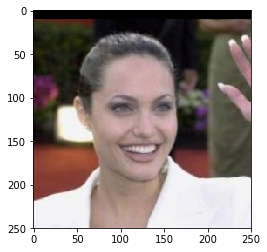

In [80]:

imagePath = 'data/photos/Angelina_Jolie/Angelina_Jolie_0001.jpg'
def shimg(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image = Image(imagePath)
shimg(image.image)

In [81]:
image.detectFaces()

In [82]:
!ls data/faces

Alexandra_Jackson     Angelina_Jolie        Arnold_Schwarzenegger
Amy_Gale              Ariel_Sharon          Atal_Bihari_Vajpayee


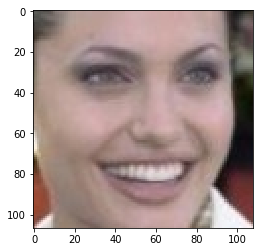

In [83]:
shimg(image.faces[0].image)

In [84]:
from imutils import paths

In [85]:
imgBaseDir = 'data/photos'
imagePaths = list(paths.list_images(imgBaseDir))
len(imagePaths)

165

In [89]:
knownEncodings = list()
knownNames = list()
import os
for (i, imagePath) in enumerate(imagePaths):
    # extract the person name from the image path
    name = imagePath.split(os.path.sep)[-2]

    image = Image(imagePath)
    image.detectFaces()
    encodings = image.faces[0].getEncodings()
    print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
    for encoding in encodings:
        knownEncodings.append(encoding)
        knownNames.append(name)


[INFO] processing image 1/165
[INFO] processing image 2/165
[INFO] processing image 3/165
[INFO] processing image 4/165
[INFO] processing image 5/165
[INFO] processing image 6/165
[INFO] processing image 7/165
[INFO] processing image 8/165
[INFO] processing image 9/165
[INFO] processing image 10/165
[INFO] processing image 11/165
[INFO] processing image 12/165
[INFO] processing image 13/165
[INFO] processing image 14/165
[INFO] processing image 15/165
[INFO] processing image 16/165
[INFO] processing image 17/165
[INFO] processing image 18/165
[INFO] processing image 19/165
[INFO] processing image 20/165
[INFO] processing image 21/165
[INFO] processing image 22/165
[INFO] processing image 23/165
[INFO] processing image 24/165
[INFO] processing image 25/165
[INFO] processing image 26/165
[INFO] processing image 27/165
[INFO] processing image 28/165
[INFO] processing image 29/165
[INFO] processing image 30/165
[INFO] processing image 31/165
[INFO] processing image 32/165
[INFO] processing

In [92]:
# dump the facial encodings + names to disk
import pickle
print("[INFO] serializing encodings...")
data = {"encodings": knownEncodings, "names": knownNames}
f = open("encodings.pkl", "wb")
f.write(pickle.dumps(data))
f.close()

[INFO] serializing encodings...


In [93]:
face_recognition.face_encodings(image.image, [image.faces[0].location])

[array([-0.08236677,  0.15997745,  0.12475944, -0.08672549, -0.17162707,
         0.01313675, -0.04598626, -0.10568751,  0.23902179, -0.10206428,
         0.26708347, -0.07410864, -0.23831907, -0.02036403,  0.06897957,
         0.13756201, -0.14203256, -0.15407851, -0.02743936,  0.02388225,
         0.04554131, -0.01629377,  0.07103417,  0.01465223, -0.16238402,
        -0.3948651 , -0.07113525,  0.00540508,  0.03238422, -0.12140103,
        -0.02998566,  0.03233147, -0.2469843 , -0.07739326,  0.06876203,
         0.18505539, -0.13036768, -0.15116644,  0.17343582, -0.07527421,
        -0.2718066 , -0.08436671,  0.07223576,  0.19848384,  0.19869727,
         0.00733013, -0.0053971 , -0.07649925,  0.11407541, -0.32619083,
         0.12401838,  0.14307846,  0.03981954,  0.05795062,  0.06950159,
        -0.1329755 ,  0.00336581,  0.18672344, -0.26112661, -0.00278847,
         0.1319316 , -0.0899472 , -0.0570017 , -0.09632191,  0.22524098,
         0.18841313, -0.12756222, -0.19458631,  0.1

In [95]:
data['names']

['Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Angelina_Jolie',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegger',
 'Arnold_Schwarzenegge

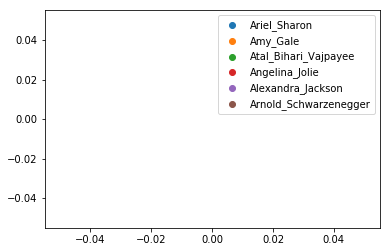